# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.
Our target accuracy is 70%, but any accuracy over 50% is a great start.
Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [2]:
# Define transforms
## YOUR CODE HERE ##
train_transform = transforms.Compose([ transforms.Resize(256),
                                    transforms.RandomResizedCrop(224),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor()])

test_transform = transforms.Compose([ transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor()])
# Create training set and define training dataloader
## YOUR CODE HERE ##
train_set = datasets.CIFAR10('root', train = True ,transform = train_transform, download = True)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
# Create test set and define test dataloader
## YOUR CODE HERE ##

test_set = datasets.CIFAR10('root', train = False ,transform = test_transform, download = True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32)
# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [3]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy()
        plt.imshow(image.T)
        plt.show()

training images: 1563
test images: 313
Image size: 224x224
ship


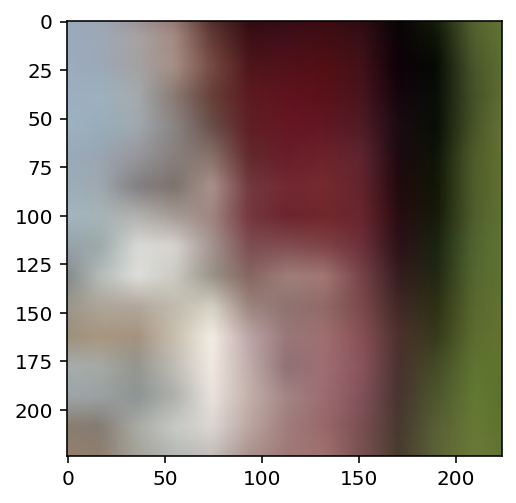

cat


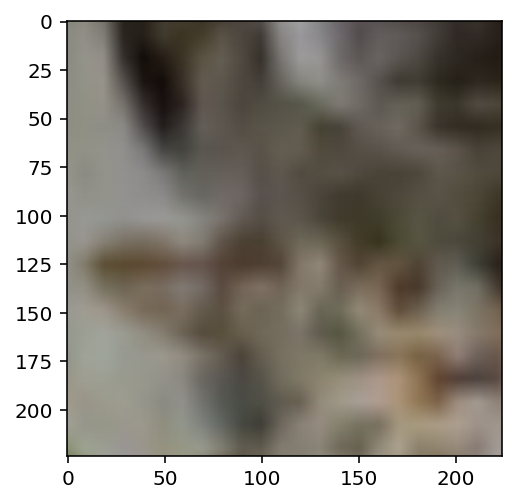

bird


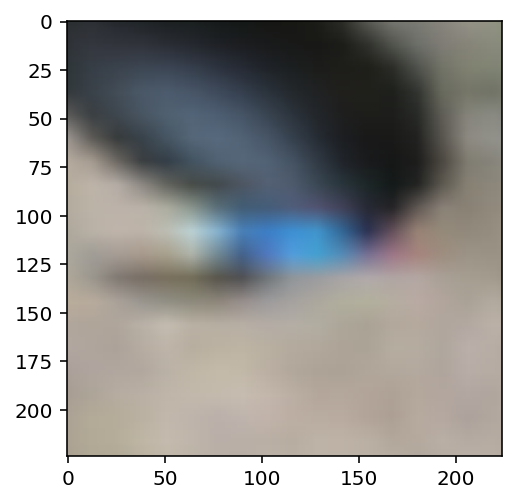

horse


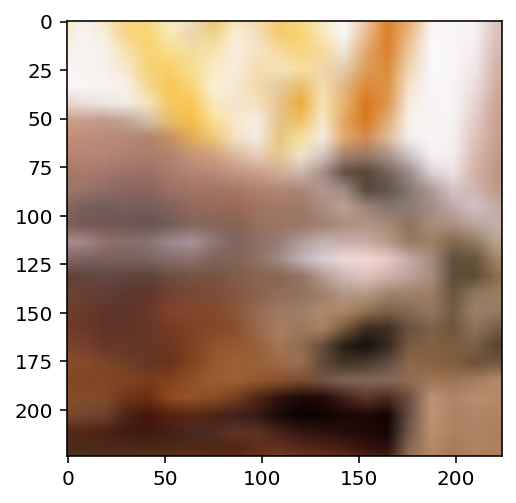

dog


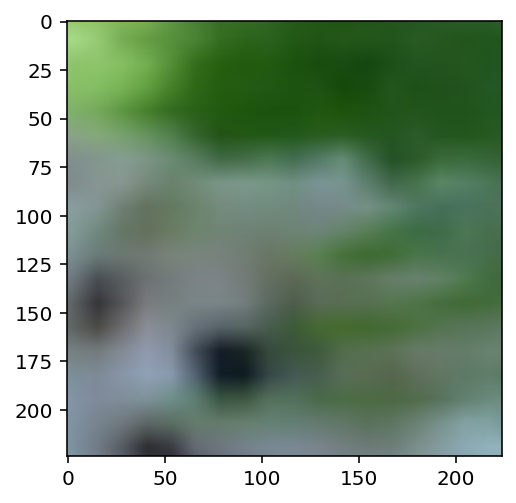

In [4]:
# Explore data
## YOUR CODE HERE ##

print(f'training images: {len(train_loader)}')
print(f'test images: {len(test_loader)}')
print(f'Image size: {next(iter(train_loader))[0][0].size(1)}x{next(iter(train_loader))[0][0].size(2)}')
show5(train_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [5]:
model = models.resnet152(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
    
classifier = nn.Sequential(nn.Linear(2048, 1024),
                          nn.ReLU(),
                          nn.Dropout(0.2),
                          nn.Linear(1024, 512),
                          nn.ReLU(),
                          nn.Dropout(0.2),
                          nn.Linear(512, 256),
                          nn.ReLU(),
                          nn.Dropout(0.2),
                          nn.Linear(256, 10),
                          nn.LogSoftmax(dim=1))

model.fc = classifier

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [6]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


batches = 250
steps = 0
running_loss = 0
epochs = 2
train_losses, test_losses = [], []

for epoch in range(epochs):
    for img, label in train_loader:
        steps += 1
        img, label = img.to(device), label.to(device)
        
        optimizer.zero_grad()
        
        output = model.forward(img)     
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % batches == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for img, label in test_loader:
                    img, label = img.to(device), label.to(device)
                    output = model.forward(img)
                    loss = criterion(output, label)
                    test_loss += loss.item()
                    
                    ps = torch.exp(output)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == label.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                
            train_losses.append(running_loss/batches)
            test_losses.append(test_loss/len(test_loader))
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/batches:.3f}.. "
                  f"Test loss: {test_loss/len(test_loader):.3f}.. "
                  f"Test accuracy: {accuracy/len(test_loader):.3f}")
            running_loss = 0
            model.train()
print('Done.')

Epoch 1/2.. Train loss: 1.946.. Test loss: 1.554.. Test accuracy: 0.442
Epoch 1/2.. Train loss: 1.702.. Test loss: 1.285.. Test accuracy: 0.522
Epoch 1/2.. Train loss: 1.624.. Test loss: 1.289.. Test accuracy: 0.498
Epoch 1/2.. Train loss: 1.587.. Test loss: 1.145.. Test accuracy: 0.626
Epoch 1/2.. Train loss: 1.591.. Test loss: 1.073.. Test accuracy: 0.633
Epoch 1/2.. Train loss: 1.567.. Test loss: 1.033.. Test accuracy: 0.655
Epoch 2/2.. Train loss: 1.523.. Test loss: 1.138.. Test accuracy: 0.608
Epoch 2/2.. Train loss: 1.531.. Test loss: 1.050.. Test accuracy: 0.656
Epoch 2/2.. Train loss: 1.517.. Test loss: 1.040.. Test accuracy: 0.665
Epoch 2/2.. Train loss: 1.483.. Test loss: 1.072.. Test accuracy: 0.665
Epoch 2/2.. Train loss: 1.499.. Test loss: 0.989.. Test accuracy: 0.673
Epoch 2/2.. Train loss: 1.522.. Test loss: 1.053.. Test accuracy: 0.647
Done.


Plot the training loss (and validation loss/accuracy, if recorded).

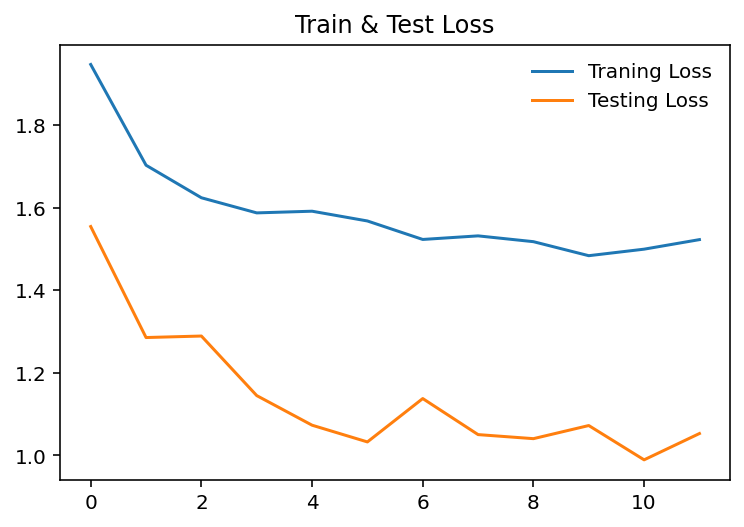

In [8]:
## YOUR CODE HERE ##

plt.plot(train_losses, label= "Traning Loss")
plt.plot(test_losses, label= "Testing Loss")
plt.legend(frameon= False)
plt.title('Train & Test Loss')
plt.show()


## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [9]:
## YOUR CODE HERE ##
model.eval()
true_pred = {classname: 0 for classname in classes}
total = {classname: 0 for classname in classes}

with torch.no_grad():
    
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        output = model.forward(imgs)
        _, predicts = torch.max(output, 1)
        for label, predict in zip(labels, predicts):
            if label == predict:
                true_pred[classes[label]] += 1
            total[classes[label]] += 1

suma = 0
print("Accuracy:")
for classname, t in true_pred.items():
    accuracy = 100 * float(t) / total[classname]
    suma += accuracy
    print(f"• Class {classname}: %{accuracy:.1f}")
print(f"Total_Accuracy: %{(suma / len(classes)):.1f}")

Accuracy:
• Class plane: %59.7
• Class car: %83.3
• Class bird: %54.2
• Class cat: %36.2
• Class deer: %39.5
• Class dog: %69.2
• Class frog: %93.6
• Class horse: %61.4
• Class ship: %71.2
• Class truck: %82.3
Total_Accuracy: %65.1


## Saving your model
Using `torch.save`, save your model for future loading.

In [10]:
## YOUR CODE HERE ##
torch.save(model.state_dict(), 'model.pth')

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.



Since we have reached 59.7, which is a percentage above the required and close to the goal, building is better than buying.

I think the model needs a larger dataset and an increase in the time period to reach greater accuracy and I run it on the CPU I hope if I run it on GPU the result will be better.